### Instructor Demo: Financial Forecasting Part III

This program executes `1000` simulations of stock price trajectory for `TSLA` and `SPHD` over the next `252 * 3` trading days (or 3 years of trading), based on a normal probability distribution of potential daily returns derived from the corresponding sample means and standard deviations. Daily and cumulative portfolio returns are then calculated, using `75%` of capital allocated to `TSLA` and `25%` of capital allocated to `SPHD`, to analyze the probability distribution and confidence interval of potential ending cumulative portfolio returns.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]

### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [4]:
# Set the list of tickers
tickers = ["TSLA", "SPHD"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-05-04", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-04", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for TSLA and SPHD.
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

SPHD                                 TSLA  \
                            open   high    low  close  volume    open   
2019-05-06 00:00:00-04:00  42.24  42.58  42.23  42.48  601263  250.10   
2019-05-07 00:00:00-04:00  42.26  42.28  41.76  42.03  692472  256.80   
2019-05-08 00:00:00-04:00  41.97  42.07  41.79  41.79  656978  246.94   
2019-05-09 00:00:00-04:00  41.60  41.79  41.34  41.72  738856  242.00   
2019-05-10 00:00:00-04:00  41.62  42.19  41.35  42.12  612070  239.75   

                                                                 
                               high       low    close   volume  
2019-05-06 00:00:00-04:00  258.3499  248.5000  255.335  9546203  
2019-05-07 00:00:00-04:00  257.2100  245.1000  247.060  9542822  
2019-05-08 00:00:00-04:00  250.5990  244.2000  244.760  5757805  
2019-05-09 00:00:00-04:00  243.6800  236.9434  241.980  6455536  
2019-05-10 00:00:00-04:00  241.9900  236.0200  239.510  6716345

### Drop Extraneous Columns

In [5]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

SPHD     TSLA
                           close    close
2019-05-06 00:00:00-04:00  42.48  255.335
2019-05-07 00:00:00-04:00  42.03  247.060
2019-05-08 00:00:00-04:00  41.79  244.760
2019-05-09 00:00:00-04:00  41.72  241.980
2019-05-10 00:00:00-04:00  42.12  239.510

### Calculate Daily Returns

In [6]:
# Use the `pct_change` function to calculate daily returns of `TSLA` and `SPHD`.
daily_returns = df.pct_change()
daily_returns.head()

SPHD      TSLA
                              close     close
2019-05-06 00:00:00-04:00       NaN       NaN
2019-05-07 00:00:00-04:00 -0.010593 -0.032408
2019-05-08 00:00:00-04:00 -0.005710 -0.009309
2019-05-09 00:00:00-04:00 -0.001675 -0.011358
2019-05-10 00:00:00-04:00  0.009588 -0.010207

### Calculate Value of Average Daily Returns

In [7]:
# Use the `mean` function to calculate the mean of daily returns for `TLSA` and `SPHD`, respectively
avg_daily_return_tsla = daily_returns.mean()['TSLA']['close']
avg_daily_return_sphd = daily_returns.mean()['SPHD']['close']
avg_daily_return_sphd

-0.000919763079205799

### Calculate Value of Standard Deviation of Daily Returns

In [8]:
# Use the `std` function to calculate the standard deviation of daily returns for `TSLA` and `SPHD`, respectively
std_dev_daily_return_tsla = daily_returns.std()['TSLA']['close']
std_dev_daily_return_sphd = daily_returns.std()['SPHD']['close']
std_dev_daily_return_sphd

0.021874972492421298

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [9]:
# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 252 * 3

# Set last closing prices of `TSLA` and `SPHD`
tsla_last_price = df['TSLA']['close'][-1]
sphd_last_price = df['SPHD']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_tsla_prices = [tsla_last_price]
    simulated_sphd_prices = [sphd_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_tsla_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return_tsla, std_dev_daily_return_tsla))
        simulated_sphd_price = simulated_sphd_prices[-1] * (1 + np.random.normal(avg_daily_return_sphd, std_dev_daily_return_sphd))
        
        # Append the simulated price to the list
        simulated_tsla_prices.append(simulated_tsla_price)
        simulated_sphd_prices.append(simulated_sphd_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["TSLA prices"] = pd.Series(simulated_tsla_prices)
    simulated_price_df["SPHD prices"] = pd.Series(simulated_sphd_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (75% TSLA; 25% SPHD)
    weights = [0.25, 0.75]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

0         1         2         3         4         5         6    \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  0.987548  0.988550  1.012886  1.016202  1.019539  0.983674  0.993246   
2  0.973185  0.981217  1.044234  0.986071  1.044171  1.014183  0.994079   
3  1.000888  0.989925  1.060164  0.978549  1.096522  1.038333  1.003872   
4  0.994136  0.996965  1.031540  0.962818  1.081661  1.043874  0.995734   

        7         8         9    ...       990       991       992       993  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  1.002746  1.004179  0.991872  ...  1.008417  0.987792  0.969014  1.054402   
2  1.011835  0.971427  0.994023  ...  1.003300  0.981657  0.973551  1.070177   
3  1.038848  0.937093  1.006052  ...  1.018230  0.949104  0.964514  1.058663   
4  1.041445  0.939820  1.005206  ...  1.029265  0.948156  0.961754  1.050014   

        994       995       996       997       998       999  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  0.972493  1.024658  0.995606  0.988616  1.043348  1.005803  
2  0.984612  1.023116  0.994936  0.974320  1.038324  1.006440  
3  0.995917  1.002070  0.964935  0.967501  1.046084  0.991861  
4  1.015540  1.014620  0.978247  0.992690  1.018204  0.996288  

[5 rows x 1000 columns]

### Plot the Multiple Simulations of Potential Cumulative Portfolio Returns over the Next 3 Years (252 * 3 Trading Days)

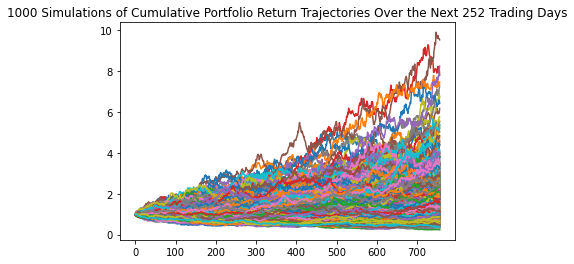

In [10]:
# Use the `plot` function to plot `1000` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [11]:
# Select the last row for projecting stock prices (prices of each simulation on the last trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    2.361777
1    0.826815
2    2.545462
3    1.630609
4    4.154863
Name: 756, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Portfolio Cumulative Returns on the Last Trading Day

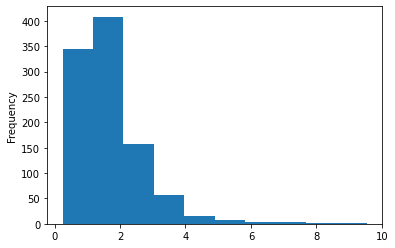

In [12]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)

### Calculate the Probability Distribution of Ending Cumulative Return Ranges

In [13]:
# Use the `value_counts` function and the `len` function to calculate the probabilities of cumulative return ranges
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(1.174, 2.104]                  0.408
(0.23399999999999999, 1.174]    0.344
(2.104, 3.034]                  0.158
(3.034, 3.964]                  0.057
(3.964, 4.893]                  0.016
(4.893, 5.823]                  0.008
(6.753, 7.683]                  0.003
(5.823, 6.753]                  0.003
(7.683, 8.613]                  0.002
(8.613, 9.543]                  0.001
Name: 756, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Cumulative Portfolio Returns

In [14]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.483880
0.975    4.374104
Name: 756, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Cumulative Portfolio Returns 

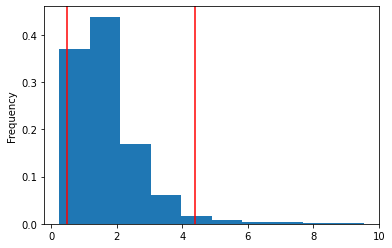

In [15]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in the Portfolio over the Next 3 Trading Years

In [16]:
# Set initial investment
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment * confidence_interval.iloc[0]
investment_pnl_upper_bound = initial_investment * confidence_interval.iloc[1]
                                                    
# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 252 * 3 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 252 * 3 trading days will end within in the range of $4838.800716620793 and $43741.044058680905


### Answer the Following Questions

* What is the expected range of projected cumulative returns of the given portfolio?
* What is the `95%` confidence interval of projected cumulative returns of the given portfolio?
* What is the `95%` confidence interval of projected cumulative investment for the given portfolio?

* The expected range of projected cumulative returns for the portfolio is between 1.174 and 2.104 with a 40.8% chance of occurring.
* The `95` confidence interval of projected cumulative returns is between 0.483880 and 4.374104.
* The `95` confidencc interval of projected cumulative investment is between 4838.80 and 43,741.04.